## Part III: Deep learning Time Series Forecasting Methods

In [1]:
import pandas as pd
import numpy as np
from keras.layers import Dropout
from keras import regularizers
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import BatchNormalization, LeakyReLU
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

# MLP

In [2]:
data = pd.read_csv('MSFT.csv')[::-1]
data = data.loc[:, 'Close'].tolist()

In [3]:
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [4]:
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = Y[0:p]
    
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
    
    X_test = X[p:]
    Y_test = y[p:]
    
    return X_train, X_test, Y_train, Y_test

In [5]:
WINDOW = 30
EMB_SIZE = 1
STEP = 1
FORECAST = 5

In [6]:
X, Y = [], []

for i in range(0, len(data), STEP):
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]
        
        last_close = x_i[WINDOW-1]
        next_close = y_i
        
        if last_close < next_close:
            y_i = [1, 0]
        else: 
            y_i = [0, 1]
            
    except Exception as e:
        print(e)
        break
        
    X.append(x_i)
    Y.append(y_i)
X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X]
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

list index out of range


In [7]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(7759, 30)
(863, 30)
(7759, 2)
(863, 2)


#### Setup 1: Simple MLP network
It has one layer. The activation functions used are LeakyReLU at the hidden layer and softmax at the output layer.

In [34]:
model = Sequential()
model.add(Dense(64, input_dim=30))
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))


In [17]:
model.layers[0].get_weights()

[array([[ 0.14755711, -0.11070062,  0.02286029, ...,  0.22158784,
         -0.15633152, -0.20594826],
        [ 0.08215261, -0.1822504 , -0.21701363, ...,  0.139786  ,
         -0.01789202, -0.18221197],
        [ 0.10305312, -0.14727785,  0.06900012, ...,  0.12886563,
          0.13454655, -0.18939587],
        ...,
        [-0.04251499, -0.10676345,  0.09702104, ...,  0.21141228,
          0.09750798, -0.16292821],
        [-0.24219516, -0.01056227,  0.17270303, ..., -0.16607797,
         -0.19687568, -0.00205222],
        [ 0.01182783,  0.22732833,  0.1341505 , ..., -0.13165453,
         -0.09496297,  0.01320866]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]

In [35]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
history = model.fit(X_train, Y_train,
                   nb_epoch=150,
                   batch_size=64,
                   verbose=1,
                   validation_data=(X_test, Y_test),
                   shuffle=True,
                   callbacks=[reduce_lr])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 7759 samples, validate on 863 samples
Epoch 1/150
7759/7759 [==============================] - 0s 41us/step - loss: 0.7028 - accuracy: 0.5409 - val_loss: 0.7120 - val_accuracy: 0.5295
Epoch 2/150
7759/7759 [==============================] - 0s 14us/step - loss: 0.6876 - accuracy: 0.5542 - val_loss: 0.6946 - val_accuracy: 0.5516
Epoch 3/150
7759/7759 [==============================] - 0s 14us/step - loss: 0.6830 - accuracy: 0.5661 - val_loss: 0.6915 - val_accuracy: 0.5620
Epoch 4/150
7759/7759 [==============================] - 0s 17us/step - loss: 0.6821 - accuracy: 0.5645 - val_loss: 0.6922 - val_accuracy: 0.5608
Epoch 5/150
7759/7759 [==============================] - 0s 16us/step - loss: 0.6809 - accuracy: 0.5597 - val_loss: 0.6882 - val_accuracy: 0.5747
Epoch 6/150
7759/7759 [==============================] - 0s 15us/step - loss: 0.6792 - accuracy: 0.5680 - val_loss: 0.6922 - val_accuracy: 0.5597
Epoch 7/150
7759/7759 [==============================] - 0s 14us/step - loss:

7759/7759 [==============================] - 0s 14us/step - loss: 0.6421 - accuracy: 0.6298 - val_loss: 0.6953 - val_accuracy: 0.5562
Epoch 103/150
7759/7759 [==============================] - 0s 14us/step - loss: 0.6423 - accuracy: 0.6305 - val_loss: 0.6973 - val_accuracy: 0.5516

Epoch 00103: ReduceLROnPlateau reducing learning rate to 0.00015009464841568844.
Epoch 104/150
7759/7759 [==============================] - 0s 14us/step - loss: 0.6418 - accuracy: 0.6266 - val_loss: 0.6904 - val_accuracy: 0.5875
Epoch 105/150
7759/7759 [==============================] - 0s 13us/step - loss: 0.6418 - accuracy: 0.6359 - val_loss: 0.6946 - val_accuracy: 0.5585
Epoch 106/150
7759/7759 [==============================] - 0s 13us/step - loss: 0.6419 - accuracy: 0.6311 - val_loss: 0.6950 - val_accuracy: 0.5713
Epoch 107/150
7759/7759 [==============================] - 0s 14us/step - loss: 0.6423 - accuracy: 0.6314 - val_loss: 0.6980 - val_accuracy: 0.5759
Epoch 108/150
7759/7759 [===================

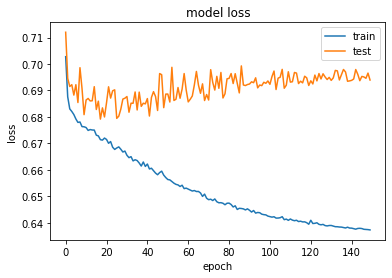

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

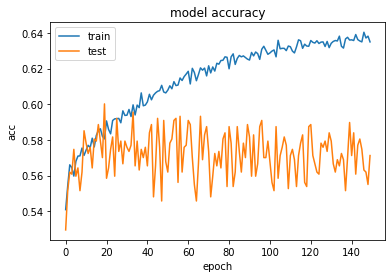

In [38]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

#### Observation:
The training data is overfitting the model because of the neural network simple nature. Since there are no regularisations or dropouts.

#### Setup 2: MLP with Regularizers, Batch Normalization and dropouts.
The model has two layers. It uses L2 or Ridge regularization with alpha =0.01. The activation function at the hidden layers is LeakyReLU and output layer is softmax.

In [31]:

model = Sequential()

model.add(Dense(64, input_dim=30, activity_regularizer=regularizers.l2(0.01)))#, kernel_initializer='uniform', bias_initializer='ones')) #zeros, ones, uniform
 
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

optimizer = Adam()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                   nb_epoch=250,
                   batch_size=128,
                   verbose=1,
                   validation_data=(X_test, Y_test),
                   shuffle=True,
                   callbacks=[reduce_lr])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 7759 samples, validate on 863 samples
Epoch 1/250
7759/7759 [==============================] - 0s 61us/step - loss: 36.1614 - accuracy: 0.4872 - val_loss: 15.1881 - val_accuracy: 0.4902
Epoch 2/250
7759/7759 [==============================] - 0s 12us/step - loss: 13.8199 - accuracy: 0.5046 - val_loss: 8.1290 - val_accuracy: 0.5469
Epoch 3/250
7759/7759 [==============================] - 0s 12us/step - loss: 8.3512 - accuracy: 0.5133 - val_loss: 5.3273 - val_accuracy: 0.5632
Epoch 4/250
7759/7759 [==============================] - 0s 12us/step - loss: 5.7793 - accuracy: 0.5181 - val_loss: 3.7925 - val_accuracy: 0.5724
Epoch 5/250
7759/7759 [==============================] - 0s 12us/step - loss: 4.2653 - accuracy: 0.5207 - val_loss: 2.8614 - val_accuracy: 0.5666
Epoch 6/250
7759/7759 [==============================] - 0s 13us/step - loss: 3.2857 - accuracy: 0.5287 - val_loss: 2.2608 - val_accuracy: 0.5771
Epoch 7/250
7759/7759 [==============================] - 0s 12us/step - lo

7759/7759 [==============================] - 0s 12us/step - loss: 0.6917 - accuracy: 0.5630 - val_loss: 0.6933 - val_accuracy: 0.5771
Epoch 56/250
7759/7759 [==============================] - 0s 12us/step - loss: 0.6913 - accuracy: 0.5579 - val_loss: 0.6876 - val_accuracy: 0.5747
Epoch 57/250
7759/7759 [==============================] - 0s 12us/step - loss: 0.6913 - accuracy: 0.5659 - val_loss: 0.6975 - val_accuracy: 0.5620
Epoch 58/250
7759/7759 [==============================] - 0s 12us/step - loss: 0.6947 - accuracy: 0.5626 - val_loss: 0.6924 - val_accuracy: 0.5771
Epoch 59/250
7759/7759 [==============================] - 0s 12us/step - loss: 0.6925 - accuracy: 0.5608 - val_loss: 0.6884 - val_accuracy: 0.5852

Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.
Epoch 60/250
7759/7759 [==============================] - 0s 12us/step - loss: 0.6914 - accuracy: 0.5655 - val_loss: 0.6884 - val_accuracy: 0.5829
Epoch 61/250
7759/7759 [==========================

Epoch 106/250
7759/7759 [==============================] - 0s 12us/step - loss: 0.6875 - accuracy: 0.5648 - val_loss: 0.6869 - val_accuracy: 0.5747
Epoch 107/250
7759/7759 [==============================] - 0s 11us/step - loss: 0.6873 - accuracy: 0.5632 - val_loss: 0.6967 - val_accuracy: 0.5724
Epoch 108/250
7759/7759 [==============================] - 0s 11us/step - loss: 0.6879 - accuracy: 0.5681 - val_loss: 0.6860 - val_accuracy: 0.5701

Epoch 00108: ReduceLROnPlateau reducing learning rate to 0.00025418660952709616.
Epoch 109/250
7759/7759 [==============================] - 0s 11us/step - loss: 0.6866 - accuracy: 0.5691 - val_loss: 0.6819 - val_accuracy: 0.5724
Epoch 110/250
7759/7759 [==============================] - 0s 11us/step - loss: 0.6870 - accuracy: 0.5609 - val_loss: 0.6889 - val_accuracy: 0.5759
Epoch 111/250
7759/7759 [==============================] - 0s 11us/step - loss: 0.6867 - accuracy: 0.5671 - val_loss: 0.6858 - val_accuracy: 0.5632
Epoch 112/250
7759/7759 [=====

Epoch 206/250
7759/7759 [==============================] - 0s 13us/step - loss: 0.6791 - accuracy: 0.5771 - val_loss: 0.6841 - val_accuracy: 0.5805

Epoch 00206: ReduceLROnPlateau reducing learning rate to 3.4336842873017304e-05.
Epoch 207/250
7759/7759 [==============================] - 0s 13us/step - loss: 0.6790 - accuracy: 0.5807 - val_loss: 0.6836 - val_accuracy: 0.5794
Epoch 208/250
7759/7759 [==============================] - 0s 12us/step - loss: 0.6797 - accuracy: 0.5820 - val_loss: 0.6833 - val_accuracy: 0.5713
Epoch 209/250
7759/7759 [==============================] - 0s 13us/step - loss: 0.6786 - accuracy: 0.5788 - val_loss: 0.6826 - val_accuracy: 0.5771
Epoch 210/250
7759/7759 [==============================] - 0s 13us/step - loss: 0.6790 - accuracy: 0.5806 - val_loss: 0.6834 - val_accuracy: 0.5805
Epoch 211/250
7759/7759 [==============================] - 0s 13us/step - loss: 0.6785 - accuracy: 0.5760 - val_loss: 0.6824 - val_accuracy: 0.5852

Epoch 00211: ReduceLROnPlatea

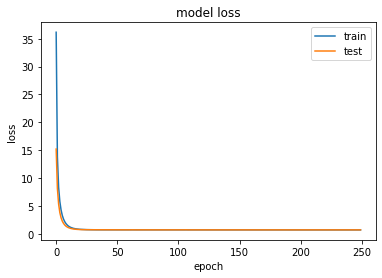

In [32]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

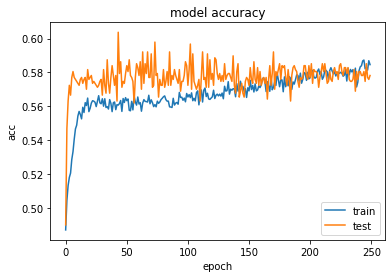

In [33]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

#### Observation:
Adding regularizers, dropouts and batch normalization there is a significant improvement in the performance of the model. This is because these techniques prevent overfitting of the data.
Dropout randomly ignores selected neurons during training. This makes the model more generalized. 

#### Setup 3: Adding more dropouts.
Dropouts have the effect of simulating a large number of networks with very different network structure and, in turn, making nodes in the network generally more robust to the inputs.

In [333]:
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})

In [90]:
model = Sequential()

model.add(Dense(64, activation=LeakyReLU(), input_dim=30))#, kernel_initializer='uniform', bias_initializer='ones', activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation=LeakyReLU()))#, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(16, activation=LeakyReLU()))#, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0.000001, verbose=1)
model.compile(optimizer="Adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                   nb_epoch=250,
                   batch_size=128,
                   verbose=1,
                   validation_data=(X_test, Y_test),
                   shuffle=True,
                   callbacks=[reduce_lr])



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 7759 samples, validate on 863 samples
Epoch 1/250
7759/7759 [==============================] - 2s 241us/step - loss: 1.0221 - accuracy: 0.5032 - val_loss: 0.6843 - val_accuracy: 0.5713
Epoch 2/250
7759/7759 [==============================] - 0s 26us/step - loss: 0.8718 - accuracy: 0.5132 - val_loss: 0.6838 - val_accuracy: 0.5759
Epoch 3/250
7759/7759 [==============================] - 0s 26us/step - loss: 0.8050 - accuracy: 0.5140 - val_loss: 0.6851 - val_accuracy: 0.5724
Epoch 4/250
7759/7759 [==============================] - 0s 26us/step - loss: 0.7542 - accuracy: 0.5289 - val_loss: 0.6832 - val_accuracy: 0.5736
Epoch 5/250
7759/7759 [==============================] - 0s 27us/step - loss: 0.7348 - accuracy: 0.5226 - val_loss: 0.6818 - val_accuracy: 0.5747
Epoch 6/250
7759/7759 [==============================] - 0s 26us/step - loss: 0.7150 - accuracy: 0.5287 - val_loss: 0.6798 - val_accuracy: 0.5736
Epoch 7/250
7759/7759 [==============================] - 0s 26us/step - loss

7759/7759 [==============================] - 0s 26us/step - loss: 0.6801 - accuracy: 0.5729 - val_loss: 0.6803 - val_accuracy: 0.5794
Epoch 103/250
7759/7759 [==============================] - 0s 26us/step - loss: 0.6804 - accuracy: 0.5685 - val_loss: 0.6803 - val_accuracy: 0.5794
Epoch 104/250
7759/7759 [==============================] - 0s 27us/step - loss: 0.6809 - accuracy: 0.5648 - val_loss: 0.6804 - val_accuracy: 0.5794
Epoch 105/250
7759/7759 [==============================] - 0s 27us/step - loss: 0.6805 - accuracy: 0.5648 - val_loss: 0.6804 - val_accuracy: 0.5794

Epoch 00105: ReduceLROnPlateau reducing learning rate to 0.00015009464841568844.
Epoch 106/250
7759/7759 [==============================] - 0s 26us/step - loss: 0.6802 - accuracy: 0.5689 - val_loss: 0.6806 - val_accuracy: 0.5794
Epoch 107/250
7759/7759 [==============================] - 0s 26us/step - loss: 0.6811 - accuracy: 0.5690 - val_loss: 0.6806 - val_accuracy: 0.5794
Epoch 108/250
7759/7759 [===================

Epoch 152/250
7759/7759 [==============================] - 0s 27us/step - loss: 0.6796 - accuracy: 0.5661 - val_loss: 0.6804 - val_accuracy: 0.5817
Epoch 153/250
7759/7759 [==============================] - 0s 26us/step - loss: 0.6802 - accuracy: 0.5663 - val_loss: 0.6804 - val_accuracy: 0.5805
Epoch 154/250
7759/7759 [==============================] - 0s 26us/step - loss: 0.6804 - accuracy: 0.5670 - val_loss: 0.6805 - val_accuracy: 0.5805
Epoch 155/250
7759/7759 [==============================] - 0s 26us/step - loss: 0.6805 - accuracy: 0.5654 - val_loss: 0.6805 - val_accuracy: 0.5805

Epoch 00155: ReduceLROnPlateau reducing learning rate to 5.233476658759173e-05.
Epoch 156/250
7759/7759 [==============================] - 0s 26us/step - loss: 0.6797 - accuracy: 0.5649 - val_loss: 0.6805 - val_accuracy: 0.5817
Epoch 157/250
7759/7759 [==============================] - 0s 27us/step - loss: 0.6795 - accuracy: 0.5700 - val_loss: 0.6805 - val_accuracy: 0.5794
Epoch 158/250
7759/7759 [======

Epoch 202/250
7759/7759 [==============================] - 0s 27us/step - loss: 0.6799 - accuracy: 0.5667 - val_loss: 0.6808 - val_accuracy: 0.5817
Epoch 203/250
7759/7759 [==============================] - 0s 26us/step - loss: 0.6800 - accuracy: 0.5670 - val_loss: 0.6808 - val_accuracy: 0.5794
Epoch 204/250
7759/7759 [==============================] - 0s 26us/step - loss: 0.6781 - accuracy: 0.5676 - val_loss: 0.6809 - val_accuracy: 0.5805
Epoch 205/250
7759/7759 [==============================] - 0s 27us/step - loss: 0.6794 - accuracy: 0.5686 - val_loss: 0.6809 - val_accuracy: 0.5817

Epoch 00205: ReduceLROnPlateau reducing learning rate to 1.8248007290821987e-05.
Epoch 206/250
7759/7759 [==============================] - 0s 26us/step - loss: 0.6791 - accuracy: 0.5664 - val_loss: 0.6809 - val_accuracy: 0.5817
Epoch 207/250
7759/7759 [==============================] - 0s 27us/step - loss: 0.6789 - accuracy: 0.5712 - val_loss: 0.6809 - val_accuracy: 0.5817
Epoch 208/250
7759/7759 [=====

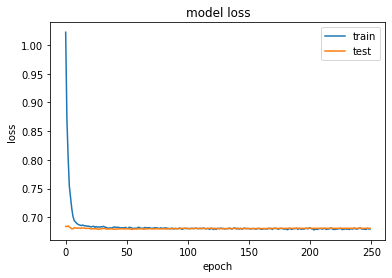

In [91]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

In [92]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print('\n Test accuracy is %.2f%%' % (scores[1]*100))


 Test accuracy is 58.05%


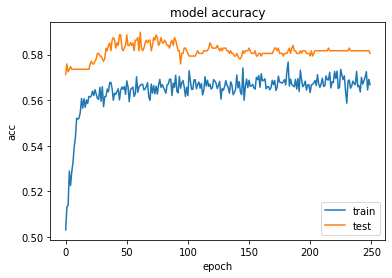

In [93]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

#### Observation:
Including dropouts with less retaining value results in a weak classifier at a layer. This will make the model a combination of many weak classifers. Thus, making the overall model more robust. Resulting in more test accuracy than the training accuracy.

# LSTM

#### Why LSTM over RNN?
LSTMs help preserve the error that can be backpropagated through time and layers. By maintaining a more constant error, they allow recurrent nets to continue to learn over many time steps.
RNN does not take long dependencies into account. For longer inputs, RNN has very little or no influence for the initial values. It, mostly, considers only the latter values for the prediction of the next value. In case of LSTMs, the entire input is considered to predict the next values due to its memory structure.
Also RNNs suffer from vanishing and exploding gradient problem which LSTMs avoid to a greater extent.

In [94]:
from keras.layers import LSTM, Dropout
from time import time

In [95]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)

(7759, 30, 1)


In [98]:
model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.3))

# model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.5))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(2))
model.add(Activation('softmax'))

optimizer=Adam()

model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 30, 64)            16896     
_________________________________________________________________
dropout_78 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_79 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_110 (Dense)            (None, 2)                 3842      
_________________________________________________________________
activation_8 (Activation)    (None, 2)               

In [99]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

startTime = time()
history = model.fit(X_train, Y_train,
                   nb_epoch=150,
                   batch_size=128,
                   verbose=1,
                   validation_data=(X_test, Y_test),
                   shuffle=True,
                   callbacks=[reduce_lr])

print('\n Elapsed time: %.3f seconds' % (time() - startTime))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Train on 7759 samples, validate on 863 samples
Epoch 1/150
7759/7759 [==============================] - 4s 552us/step - loss: 0.6862 - accuracy: 0.5497 - val_loss: 0.6781 - val_accuracy: 0.5921
Epoch 2/150
7759/7759 [==============================] - 2s 316us/step - loss: 0.6833 - accuracy: 0.5588 - val_loss: 0.6793 - val_accuracy: 0.5829
Epoch 3/150
7759/7759 [==============================] - 3s 329us/step - loss: 0.6826 - accuracy: 0.5641 - val_loss: 0.6764 - val_accuracy: 0.5910
Epoch 4/150
7759/7759 [==============================] - 3s 363us/step - loss: 0.6820 - accuracy: 0.5652 - val_loss: 0.6816 - val_accuracy: 0.5620
Epoch 5/150
7759/7759 [==============================] - 3s 358us/step - loss: 0.6827 - accuracy: 0.5630 - val_loss: 0.6760 - val_accuracy: 0.5910
Epoch 6/150
7759/7759 [==============================] - 3s 335us/step - loss: 0.6816 - accuracy: 0.5642 - val_loss: 0.6782 - val_accuracy: 0.5805
Epoch 7/150
7759/7759 [==============================] - 3s 356us/step 

7759/7759 [==============================] - 3s 375us/step - loss: 0.6785 - accuracy: 0.5761 - val_loss: 0.6798 - val_accuracy: 0.5782
Epoch 108/150
7759/7759 [==============================] - 3s 392us/step - loss: 0.6787 - accuracy: 0.5713 - val_loss: 0.6798 - val_accuracy: 0.5782
Epoch 109/150
7759/7759 [==============================] - 3s 368us/step - loss: 0.6784 - accuracy: 0.5703 - val_loss: 0.6798 - val_accuracy: 0.5782
Epoch 110/150
7759/7759 [==============================] - 3s 368us/step - loss: 0.6787 - accuracy: 0.5698 - val_loss: 0.6798 - val_accuracy: 0.5782
Epoch 111/150
7759/7759 [==============================] - 3s 365us/step - loss: 0.6791 - accuracy: 0.5735 - val_loss: 0.6798 - val_accuracy: 0.5782
Epoch 112/150
7759/7759 [==============================] - 3s 366us/step - loss: 0.6785 - accuracy: 0.5740 - val_loss: 0.6798 - val_accuracy: 0.5782
Epoch 113/150
7759/7759 [==============================] - 3s 364us/step - loss: 0.6785 - accuracy: 0.5694 - val_loss: 0

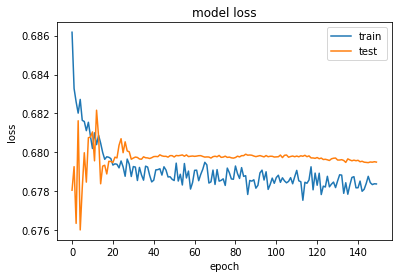

In [100]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

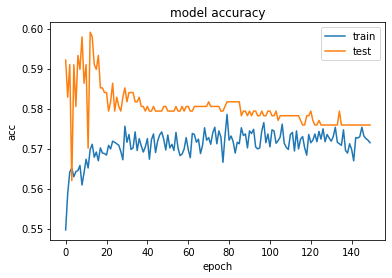

In [101]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

In [102]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print('\n Test accuracy is %.2f%%' % (scores[1]*100))


 Test accuracy is 57.59%


### Dataset: 
1. https://finance.yahoo.com/quote/MSFT/history/

### Project References:
1. https://people.duke.edu/~rnau/411arim.htm
2. https://www.deeplearning.ai/ai-notes/initialization/
3. https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
4. https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
5. https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html
6. https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/